# **Model Building and Evaluation**

## Objectives

* **Business Requirement 2:**
    * Develop a machine learning model to predict the sale price of Lydia's four inherited houses and any house in Ames, Iowa, with at least 75% accuracy.

## Inputs

* Main Dataset:
    * 'outputs/datasets/collection/HousePricing.csv'
    
* Inherited Houses Dataset:
    * 'outputs/datasets/collection/InheritedHouses.csv'

## Outputs

* **Trained Models:** Linear Regression, Random Forest, XGBoost models trained to predict house prices.

* **Predicted Sale Prices:** Predictions of house prices for Lydia's inherited houses using the trained models.

* **Comparison Table:** A summary table comparing the performance of the three models based on R² and Mean Squared Error (MSE) on both training and testing datasets.

* **CSV File with Predictions:** The predicted sale prices of the inherited houses saved to 'outputs/datasets/collection/inherited_houses_predictions.csv'.

## Install Python packages in the Notebook

In [1]:
%pip install -r /workspace/HeritageHousing/requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Change working directory

Before starting we need to change to the correct directory (from where it is to its parent folder).

We first access the current directory using os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/HeritageHousing/notebooks'

We want to make the parent of the current directory the new current directory.

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Below will confirm the current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/HeritageHousing'

## Libraries Import

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


## Load the Datasets

Loading the main dataset and the inherited houses data and checking to make sure they load correctly

In [6]:
df = pd.read_csv('outputs/datasets/collection/HousePricing.csv')
inherited_houses = pd.read_csv('outputs/datasets/collection/InheritedHouses.csv')

In [7]:
print("Main Housing Dataset:")
df.head()

Main Housing Dataset:


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


In [8]:
print("\nInherited Houses Dataset:")
inherited_houses.head()


Inherited Houses Dataset:


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


## Data Cleaning

In this step, we will handle missing values and ensure the data is in good shape for model training. We'll apply the same cleaning steps to both the main dataset and the inherited house dataset.

**Check for Missing Values**

First, let's check for missing values in both datasets.

In [9]:
print("Missing values in the main housing dataset:")
print(df.isnull().sum().sort_values(ascending=False))

Missing values in the main housing dataset:
EnclosedPorch    1324
WoodDeckSF       1305
LotFrontage       259
GarageFinish      235
BsmtFinType1      145
BedroomAbvGr       99
2ndFlrSF           86
GarageYrBlt        81
BsmtExposure       38
MasVnrArea          8
1stFlrSF            0
BsmtFinSF1          0
BsmtUnfSF           0
GrLivArea           0
LotArea             0
GarageArea          0
KitchenQual         0
OpenPorchSF         0
OverallQual         0
OverallCond         0
TotalBsmtSF         0
YearBuilt           0
YearRemodAdd        0
SalePrice           0
dtype: int64


In [10]:
print("\nMissing values in the inherited houses dataset:")
print(inherited_houses.isnull().sum().sort_values(ascending=False))


Missing values in the inherited houses dataset:
1stFlrSF         0
2ndFlrSF         0
BedroomAbvGr     0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinType1     0
BsmtUnfSF        0
EnclosedPorch    0
GarageArea       0
GarageFinish     0
GarageYrBlt      0
GrLivArea        0
KitchenQual      0
LotArea          0
LotFrontage      0
MasVnrArea       0
OpenPorchSF      0
OverallCond      0
OverallQual      0
TotalBsmtSF      0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
dtype: int64


**Handling Missing Values**

Now that we have identified which columns have missing values, we will handle them based on the nature of each feature. We'll apply the same strategy we used earlier for the main dataset and inherited houses.

* **Handling Missing Values in Main Housing Data**

In [11]:
# For 'EnclosedPorch' and 'WoodDeckSF', assume missing means the absence of those features. Fill with 0.
df['EnclosedPorch'].fillna(0, inplace=True)
df['WoodDeckSF'].fillna(0, inplace=True)

# For 'LotFrontage', fill with the median value as it’s a critical numeric feature.
df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace=True)

# For 'GarageFinish' and 'GarageYrBlt', assume missing means no garage. Fill with 'No Garage' and 0 respectively.
df['GarageFinish'].fillna('No Garage', inplace=True)
df['GarageYrBlt'].fillna(0, inplace=True)

# For 'BsmtFinType1' and 'BsmtExposure', assume missing means no basement. Fill with 'No Basement' and 'No Exposure'.
df['BsmtFinType1'].fillna('No Basement', inplace=True)
df['BsmtExposure'].fillna('No Exposure', inplace=True)

# For 'BedroomAbvGr', fill with the mode (most common number of bedrooms).
df['BedroomAbvGr'].fillna(df['BedroomAbvGr'].mode()[0], inplace=True)

# For '2ndFlrSF', assume missing means no second floor. Fill with 0.
df['2ndFlrSF'].fillna(0, inplace=True)

# For 'MasVnrArea', assume missing means no masonry veneer. Fill with 0.
df['MasVnrArea'].fillna(0, inplace=True)


/tmp/ipykernel_4451/3255318329.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['EnclosedPorch'].fillna(0, inplace=True)
/tmp/ipykernel_4451/3255318329.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

* **Handling Missing Values in the Inherited Houses Dataset**

We will use the same strategy for the inherited house data

In [12]:
# Fill missing values for inherited houses in the same way
inherited_houses['EnclosedPorch'].fillna(0, inplace=True)
inherited_houses['WoodDeckSF'].fillna(0, inplace=True)
inherited_houses['LotFrontage'].fillna(inherited_houses['LotFrontage'].median(), inplace=True)
inherited_houses['GarageFinish'].fillna('No Garage', inplace=True)
inherited_houses['GarageYrBlt'].fillna(0, inplace=True)
inherited_houses['BsmtFinType1'].fillna('No Basement', inplace=True)
inherited_houses['BsmtExposure'].fillna('No Exposure', inplace=True)
inherited_houses['BedroomAbvGr'].fillna(inherited_houses['BedroomAbvGr'].mode()[0], inplace=True)
inherited_houses['2ndFlrSF'].fillna(0, inplace=True)
inherited_houses['MasVnrArea'].fillna(0, inplace=True)


/tmp/ipykernel_4451/3804297574.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inherited_houses['EnclosedPorch'].fillna(0, inplace=True)
/tmp/ipykernel_4451/3804297574.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

* **Check for Missing Values Again**

After handling the missing values, it's a good practice to check again to make sure there are no remaining missing values.

In [13]:
print("Missing values in the main housing dataset:")
print(df.isnull().sum().sort_values(ascending=False))

Missing values in the main housing dataset:
1stFlrSF         0
2ndFlrSF         0
BedroomAbvGr     0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinType1     0
BsmtUnfSF        0
EnclosedPorch    0
GarageArea       0
GarageFinish     0
GarageYrBlt      0
GrLivArea        0
KitchenQual      0
LotArea          0
LotFrontage      0
MasVnrArea       0
OpenPorchSF      0
OverallCond      0
OverallQual      0
TotalBsmtSF      0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
SalePrice        0
dtype: int64


In [14]:
print("\nMissing values in the inherited houses dataset:")
print(inherited_houses.isnull().sum().sort_values(ascending=False))


Missing values in the inherited houses dataset:
1stFlrSF         0
2ndFlrSF         0
BedroomAbvGr     0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinType1     0
BsmtUnfSF        0
EnclosedPorch    0
GarageArea       0
GarageFinish     0
GarageYrBlt      0
GrLivArea        0
KitchenQual      0
LotArea          0
LotFrontage      0
MasVnrArea       0
OpenPorchSF      0
OverallCond      0
OverallQual      0
TotalBsmtSF      0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
dtype: int64


## Feature Engineering

In this step, we'll create new features and transform categorical data into numerical data, preparing the dataset for modeling.

* **Creating New Features**

Since we’ve already discussed that total square footage (TotalSF) is an important attribute, we’ll create that feature by summing up the square footage from the first floor, second floor, and basement.

In [15]:
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
inherited_houses['TotalSF'] = inherited_houses['1stFlrSF'] + inherited_houses['2ndFlrSF'] + inherited_houses['TotalBsmtSF']

In [16]:
df[['TotalSF', 'SalePrice']].head()

,TotalSF,SalePrice
0,2566.0,208500
1,2524.0,181500
2,2706.0,223500
3,1717.0,140000
4,2290.0,250000


In [17]:
inherited_houses[['TotalSF']].head()

,TotalSF
0,1778.0
1,2658.0
2,2557.0
3,2530.0


* **Encoding Categorical Variables**

We need to convert categorical variables into numeric ones for the machine learning algorithms to process them. Since the categories (like quality ratings) have an inherent order, we’ll use label encoding for categorical features such as BsmtExposure, BsmtFinType1, GarageFinish, and KitchenQual.

Define mappings for each categorical column

In [18]:
bsmt_exposure_mapping = {'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3, 'No Exposure': 4}
bsmt_fin_type_mapping = {'No Basement': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
garage_finish_mapping = {'No Garage': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
kitchen_qual_mapping = {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}

Apply the mappings to the main dataset

In [19]:
df['BsmtExposure'] = df['BsmtExposure'].map(bsmt_exposure_mapping)
df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmt_fin_type_mapping)
df['GarageFinish'] = df['GarageFinish'].map(garage_finish_mapping)
df['KitchenQual'] = df['KitchenQual'].map(kitchen_qual_mapping)

Apply the mappings to the inherited houses dataset

In [20]:
inherited_houses['BsmtExposure'] = inherited_houses['BsmtExposure'].map(bsmt_exposure_mapping)
inherited_houses['BsmtFinType1'] = inherited_houses['BsmtFinType1'].map(bsmt_fin_type_mapping)
inherited_houses['GarageFinish'] = inherited_houses['GarageFinish'].map(garage_finish_mapping)
inherited_houses['KitchenQual'] = inherited_houses['KitchenQual'].map(kitchen_qual_mapping)

Display the first few rows of the main dataset to verify the mappings

In [21]:
df[['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']].head()

,BsmtExposure,BsmtFinType1,GarageFinish,KitchenQual
0,0,6,2,2
1,3,5,2,1
2,1,6,2,2
3,0,5,1,2
4,2,6,2,2


Display the first few rows of the inherited houses dataset to verify the mappings

In [22]:
inherited_houses[['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']].head()

,BsmtExposure,BsmtFinType1,GarageFinish,KitchenQual
0,0,3,1,1
1,0,5,1,2
2,0,6,3,1
3,0,6,3,2


* **Final Check Before Model Building**

Ensure there are no categorical variables left and confirm the data types of all columns.

In [23]:
print("Data types in the main dataset:")
print(df.dtypes)

Data types in the main dataset:
1stFlrSF           int64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure       int64
BsmtFinSF1         int64
BsmtFinType1       int64
BsmtUnfSF          int64
EnclosedPorch    float64
GarageArea         int64
GarageFinish       int64
GarageYrBlt      float64
GrLivArea          int64
KitchenQual        int64
LotArea            int64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF        int64
OverallCond        int64
OverallQual        int64
TotalBsmtSF        int64
WoodDeckSF       float64
YearBuilt          int64
YearRemodAdd       int64
SalePrice          int64
TotalSF          float64
dtype: object


In [24]:
print("\nData types in the inherited houses dataset:")
print(inherited_houses.dtypes)


Data types in the inherited houses dataset:
1stFlrSF           int64
2ndFlrSF           int64
BedroomAbvGr       int64
BsmtExposure       int64
BsmtFinSF1       float64
BsmtFinType1       int64
BsmtUnfSF        float64
EnclosedPorch      int64
GarageArea       float64
GarageFinish       int64
GarageYrBlt      float64
GrLivArea          int64
KitchenQual        int64
LotArea            int64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF        int64
OverallCond        int64
OverallQual        int64
TotalBsmtSF      float64
WoodDeckSF         int64
YearBuilt          int64
YearRemodAdd       int64
TotalSF          float64
dtype: object


## Splitting the Data

In this step we will be splitting the main dataset into training and testing sets. The training set will be use to build the model, and the testing set will be used to evaluate its performance.

We will split the data as follow:

* **Training Set:** 80% of the data, used to train the model.

* **Testing Set:** 20% of the data, used to test the models performance.

* **Define the Target and Features**

We need to specify the target variable (SalePrice) and the features (all other columns, except SalePrice).


In [25]:
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (1460, 24)
Target shape: (1460,)


* **Splitting the Data**

We will use train_test_split from scikit-learn to split the data into training and testing sets.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

Training Features Shape: (1168, 24)
Testing Features Shape: (292, 24)
Training Target Shape: (1168,)
Testing Target Shape: (292,)


* **Save the Test Data to .csv files**

Before moving to model selection training we will save the training and test data to .csv files.

In [27]:
X_train.to_csv('outputs/datasets/collection/X_train.csv', index=False)
y_train.to_csv('outputs/datasets/collection/y_train.csv', index=False)

X_test.to_csv('outputs/datasets/collection/X_test.csv', index=False)
y_test.to_csv('outputs/datasets/collection/y_test.csv', index=False)

inherited_houses.to_csv('outputs/datasets/collection/inherited_houses_cleaned.csv', index=False)

## Model Selection and Training

Now we will choose a machine learning model and train it using the training data. Given that we are working on a regression problem (predicting house prices), we will start with a basic model: Linear Regression. Afterwards we can look at more advanced models like Random Forest.

* **Training a Linear Regression Model**

Linear Regression is one of the simplest and most interpretable models making it a good starting point. We will use this for baseline performance.

Import the Linear Regression model from scikit-learn

In [28]:
from sklearn.linear_model import LinearRegression

Initialize the Linear Regression model

In [29]:
lr_model = LinearRegression()

Train (fit) the model using the training data

In [30]:
lr_model.fit(X_train, y_train)

print("Model Coefficients:", lr_model.coef_)
print("Model Intercept:", lr_model.intercept_)

Model Coefficients: [ 3.26379554e+00  3.05497250e+00 -3.19791830e+03  4.78944410e+03
  4.48024041e+00  9.61087107e+02 -4.27156220e+00 -3.07625597e+01
  4.25526227e+01  1.89462626e+03 -8.51840327e+00  3.56592866e+01
  1.53495942e+04  5.09543222e-01 -5.54991098e+01  2.02944902e+01
 -1.09976220e+01  4.54595967e+03  1.68056481e+04  5.13047283e+00
  1.48723996e+01  2.76525475e+02  5.11737314e+01  1.14492409e+01]
Model Intercept: -718079.6067312461


* **Evaluate the Model**

After training the model we need to evaluate its performance on both the training and testing sets. We will use R² (coefficient of determination) and mean squared error (MSE) as the evaluation metrics.

Import evaluation metrics

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

Make predictions on the training and testing sets

In [32]:
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

Evaluate the model on the training set

In [33]:
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

print(f"Training R²: {train_r2:.2f}")
print(f"Training Mean Squared Error: {train_mse:.2f}")

Training R²: 0.80
Training Mean Squared Error: 1209341991.66


Evaluate the model on the testing set

In [34]:
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Testing R²: {test_r2:.2f}")
print(f"Testing Mean Squared Error: {test_mse:.2f}")

Testing R²: 0.83
Testing Mean Squared Error: 1270949169.17


Testing R² of 0.83 exceeds the performance criteria of at least 0.75, meaning that the model generalizes well to the unseen testing data. This indicates that the model is performing well both on the training and testing sets.

The Mean Squared Error (MSE) of 1.27 billion shows some variability in predictions, but given that the R² score is strong, the model is likely capturing the overall relationships between house attributes and sale prices effectively.

**Summary of Performance:**

* Training R²: 0.80

* Testing R²: 0.83

* Performance Criteria: Met on both training and testing sets.

* **Predicting Prices for Inherited Houses**

Now that the model is trained, we can use it to predict the sale prices of Lydia’s inherited houses.

Predict the sale prices for the inherited houses using the trained model

In [35]:
inherited_houses_predictions = lr_model.predict(inherited_houses)

Add the predictions as a new column in the inherited houses dataset

In [36]:
inherited_houses['Predicted_SalePrice'] = inherited_houses_predictions

Display the inherited houses with predicted sale prices

In [37]:
inherited_houses[['TotalSF', 'Predicted_SalePrice']]

,TotalSF,Predicted_SalePrice
0,1778.0,128197.463809
1,2658.0,177863.198534
2,2557.0,169824.121692
3,2530.0,203749.739893


## Model Optimization

* **Advanced Models**

The first step in optimization is to try more powerful models. We'll start by exploring two well-known algorithms:

* Random Forest

* XGBoost

These models are often better at capturing complex patterns in data compared to Linear Regression.

* **Training a Random Forest Model**

A Random Forest is an ensemble model that uses multiple decision trees to improve prediction accuracy.

In [38]:
# Import the Random Forest Regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train (fit) the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Evaluate the model on the training set
train_r2_rf = rf_model.score(X_train, y_train)
print(f"Training R² (Random Forest): {train_r2_rf:.2f}")

# Evaluate the model on the testing set
test_r2_rf = rf_model.score(X_test, y_test)
print(f"Testing R² (Random Forest): {test_r2_rf:.2f}")


Training R² (Random Forest): 0.98
Testing R² (Random Forest): 0.89


* **Training an XGBoost Model**

XGBoost is another powerful ensemble model that often performs well in regression tasks.

In [39]:
# Import the XGBoost Regressor
from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Train (fit) the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Evaluate the model on the training set
train_r2_xgb = xgb_model.score(X_train, y_train)
print(f"Training R² (XGBoost): {train_r2_xgb:.2f}")

# Evaluate the model on the testing set
test_r2_xgb = xgb_model.score(X_test, y_test)
print(f"Testing R² (XGBoost): {test_r2_xgb:.2f}")


Training R² (XGBoost): 1.00
Testing R² (XGBoost): 0.90


* **Using Random Forest and XGBoost models on Inherited Houses Data to see if Hyperparameter tuning is needed**

The results of the testing on the Training and Test datasets are as follow:

* **Training R² (Random Forest): 0.98**

* **Testing R² (Random Forest): 0.89**

* **Training R² (XGBoost): 1.00**

* **Testing R² (XGBoost): 0.90**

Given that these scores exceed expectations we will run the Inherited Houses data through the models to check preformace

In [40]:
# Drop any columns that are not part of the original features used during training
inherited_houses_for_prediction = inherited_houses[X_train.columns]

# Verify that the columns match between the training data and the inherited houses data
print("Inherited houses columns (after dropping extra columns):", inherited_houses_for_prediction.columns)
print("Training data columns:", X_train.columns)

Inherited houses columns (after dropping extra columns): Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
       'TotalSF'],
      dtype='object')
Training data columns: Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
       'TotalSF'],
      dtype='object')


In [41]:
# Predict the sale prices for the inherited houses using the Random Forest model
inherited_houses_rf_predictions = rf_model.predict(inherited_houses_for_prediction)

# Add the Random Forest predictions as a new column in the inherited houses dataset
inherited_houses['Predicted_SalePrice_RF'] = inherited_houses_rf_predictions

# Display the inherited houses with predicted sale prices using Random Forest
print("Inherited Houses Predictions - Random Forest:")
inherited_houses[['TotalSF', 'Predicted_SalePrice_RF']]


Inherited Houses Predictions - Random Forest:


,TotalSF,Predicted_SalePrice_RF
0,1778.0,126131.83
1,2658.0,171036.20
2,2557.0,173869.55
3,2530.0,183393.44


In [42]:
# Predict the sale prices for the inherited houses using the XGBoost model
inherited_houses_xgb_predictions = xgb_model.predict(inherited_houses_for_prediction)

# Add the XGBoost predictions as a new column in the inherited houses dataset
inherited_houses['Predicted_SalePrice_XGB'] = inherited_houses_xgb_predictions

# Display the inherited houses with predicted sale prices using XGBoost
print("Inherited Houses Predictions - XGBoost:")
inherited_houses[['TotalSF', 'Predicted_SalePrice_XGB']]


Inherited Houses Predictions - XGBoost:


,TotalSF,Predicted_SalePrice_XGB
0,1778.0,126437.609375
1,2658.0,153235.796875
2,2557.0,182358.859375
3,2530.0,196840.343750


In [43]:
# Save the predictions to a CSV file
inherited_houses.to_csv('/workspace/HeritageHousing/outputs/datasets/collection/inherited_houses_predictions.csv', index=False)


## Model Evaluation & Comparison

Now we will create a summary table comparing the performance of the Linear Regression, Random Forest, and XGBoost models on both the training and testing datasets. We will use the metrics R² and Mean Squared Error (MSE) for comparison.

Steps to proceed:

* Compute the R² and MSE for all models on both training and testing data.

* Organize these results into a pandas DataFrame for easy comparison.

* Display the table.


In [44]:
# Linear Regression
train_r2_lr = r2_score(y_train, y_train_pred)
test_r2_lr = r2_score(y_test, y_test_pred)
train_mse_lr = mean_squared_error(y_train, y_train_pred)
test_mse_lr = mean_squared_error(y_test, y_test_pred)

# Random Forest
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)

# XGBoost
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)

# Print the R² and MSE for each model
print(f"Linear Regression - Training R²: {train_r2_lr:.2f}, Testing R²: {test_r2_lr:.2f}")
print(f"Linear Regression - Training MSE: {train_mse_lr:.2f}, Testing MSE: {test_mse_lr:.2f}\n")

print(f"Random Forest - Training R²: {train_r2_rf:.2f}, Testing R²: {test_r2_rf:.2f}")
print(f"Random Forest - Training MSE: {train_mse_rf:.2f}, Testing MSE: {test_mse_rf:.2f}\n")

print(f"XGBoost - Training R²: {train_r2_xgb:.2f}, Testing R²: {test_r2_xgb:.2f}")
print(f"XGBoost - Training MSE: {train_mse_xgb:.2f}, Testing MSE: {test_mse_xgb:.2f}\n")


Linear Regression - Training R²: 0.80, Testing R²: 0.83
Linear Regression - Training MSE: 1209341991.66, Testing MSE: 1270949169.17

Random Forest - Training R²: 0.98, Testing R²: 0.89
Random Forest - Training MSE: 120843347.91, Testing MSE: 860818070.44

XGBoost - Training R²: 1.00, Testing R²: 0.90
XGBoost - Training MSE: 1825791.03, Testing MSE: 786374777.85



* **Organize the Results into a DataFrame**

In [45]:
# Create a DataFrame with the results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Training R²': [train_r2_lr, train_r2_rf, train_r2_xgb],
    'Testing R²': [test_r2_lr, test_r2_rf, test_r2_xgb],
    'Training MSE': [train_mse_lr, train_mse_rf, train_mse_xgb],
    'Testing MSE': [test_mse_lr, test_mse_rf, test_mse_xgb]
})

# Display the DataFrame
results

,Model,Training R²,Testing R²,Training MSE,Testing MSE
0,Linear Regression,0.797245,0.834303,1.209342e+09,1.270949e+09
1,Random Forest,0.979740,0.887773,1.208433e+08,8.608181e+08
2,XGBoost,0.999694,0.897478,1.825791e+06,7.863748e+08


## Saving the Model

As we will be using the XGBoost model we will save it for later use so we dont have to retrain it.

Create the 'outputs/models' directory

In [47]:
os.makedirs('outputs/models', exist_ok=True)

Save the model to the specified path

In [48]:
joblib.dump(xgb_model, 'outputs/models/xgb_model.pkl')

['outputs/models/xgb_model.pkl']

## Final Visualization

<Figure size 800x500 with 0 Axes>

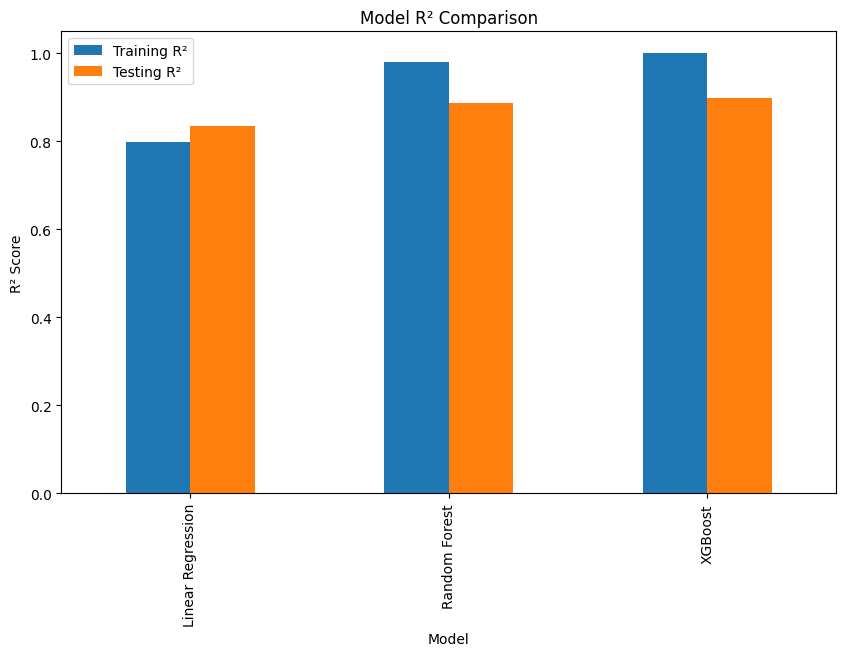

In [49]:
plt.figure(figsize=(8,5))
results.plot(x='Model', y=['Training R²', 'Testing R²'], kind='bar', title='Model R² Comparison', figsize=(10,6))
plt.ylabel('R² Score')
plt.show()

## Conclusion

In this notebook, we achieved the following:

### **Data Preparation:**
- Cleaned the main and inherited house datasets by handling missing values and performing feature engineering (like creating the TotalSF feature).
- Encoded categorical variables to numerical formats for use in machine learning models.

### **Model Building and Evaluation:**
- Trained three models: Linear Regression, Random Forest, and XGBoost.
- Evaluated all models using R² and Mean Squared Error (MSE) on both training and testing datasets.
- Generated predictions for Lydia’s inherited houses using all three models.

### **Model Comparison:**
- XGBoost outperformed the other models with the highest R² score on both training (0.999) and testing (0.897) sets, and the lowest MSE on the testing set.
- Random Forest also performed well but had a slightly lower R² score on the testing set (0.887).
- Linear Regression had the lowest performance in terms of R² and MSE.

### **Final Model Selection:**
Based on the comparison of models, **XGBoost** was selected as the best-performing model, as it generalizes well and provides the highest prediction accuracy for house prices. This model was saved for future use.

